In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import glob

In [36]:
CONFIG_PATH = "/home/office5/ATE/Ketan_sir/"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")
config

{'l_thresh': 20,
 'u_thresh': 245,
 't_lower': 100,
 't_upper': 200,
 'L2Gradient': True,
 'connectivity': 4,
 'get_pixel_img1': 5,
 'get_pixel_img2': 10,
 'get_kernel_size_value': 1,
 'debug': False,
 'y_size': 200,
 'x_size': 500}

## Get crop portion of image

In [37]:
def show(img):
    plt.figure(figsize = (15,12))
    plt.imshow(img)
    plt.show()

In [38]:
def get_edge_image(img_path):
    # Assume the image come is cropped part
    # img = cv2.imread(img_path)
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(img_path,config['l_thresh'],config['u_thresh'],cv2.THRESH_BINARY)[1]
    edge = cv2.Canny(thresh, config['t_lower'], config['t_upper'], L2gradient = config['L2Gradient'])
    return edge,img_path

def get_connected_comp_img(edge):
    lst_component = []
    output = cv2.connectedComponentsWithStats(edge, config['connectivity'], cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        if i == 0:
            text = "examining component {}/{} (background)".format(
                i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format( i + 1, numLabels)
        # x_ = stats[i, cv2.CC_STAT_LEFT]
        # y_ = stats[i, cv2.CC_STAT_TOP]
        w_ = stats[i, cv2.CC_STAT_WIDTH]
        h_ = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        keepWidth = w_ > 2
        keepHeight = h_ > 2
        keepArea = area > 50

        if all((keepWidth, keepHeight, keepArea)):
            componentMask = (labels == i).astype("uint8") * 255
            # print(componentMask)
            # cv2.imwrite(f"/home/office5/Image_Code/Ketan_sir/try1_fun_component/{i}.png",componentMask)
            color_img  = cv2.cvtColor(componentMask,cv2.COLOR_GRAY2BGR)
            lst_component.append(color_img)
    return lst_component

In [39]:
def get_extreme_point(all_component_image):

    # to store all extreme point
    extr_point = []


    # Here define range from 1 to n because 0 image is backgroumd
    for i in range(1,len(all_component_image)):
        gray = cv2.cvtColor(all_component_image[i],cv2.COLOR_BGR2GRAY)
        coords = np.column_stack(np.where(gray == 255))

        # print(coords)
        a = np.min(coords,axis=0)
        b = np.max(coords,axis=0)

        y_min,x_min,y_max,x_max = a[0],a[1],b[0],b[1]

        points = []

        # for i in range(len(coords)):
        #     if(y_min == coords[i][0]):
        #         pass
        #     else:
        #         points.append([coords[i-1][0], coords[i-1][1]]) 
        #         break
            
        for i in range(len(coords)):
            if(x_min == coords[i][1]):
                points.append([coords[i][0], coords[i][1]]) 
                break
            else:
                pass
        points.append([coords[-1][0] , coords[-1][1]])
        points = np.array(points)

        for i in range(2):
            extr_point.append([points[i][0], points[i][1]])

    return extr_point
        


In [40]:
def get_index_kernel(ori_gray, extreme_point_arr, set_kernel_value):

    y1_s = extreme_point_arr[0] - config['get_kernel_size_value']
    y2_s = extreme_point_arr[0] + config['get_kernel_size_value']
    x1_s = extreme_point_arr[1] - config['get_kernel_size_value']
    x2_s = extreme_point_arr[1] + config['get_kernel_size_value']

    try:
        kernel_value =  ori_gray[y1_s:y2_s + 1,x1_s:x2_s + 1]
        
        for i in range(len(kernel_value[0])):
            for j in range(len(kernel_value[1])):
                set_kernel_value[i][j] = (np.subtract(int(kernel_value[config['get_kernel_size_value']][config['get_kernel_size_value']]),int(kernel_value[i][j])))
                set_kernel_value[config['get_kernel_size_value']][config['get_kernel_size_value']] = 5 
                if(set_kernel_value[i][j]==0):
                    set_kernel_value[i][j] = 1
                elif(set_kernel_value[i][j]<0):
                    set_kernel_value[i][j] = 0
                else:
                    set_kernel_value[i][j] = 1
    except:
        set_kernel_value = np.zeros((3,3))
    return set_kernel_value

In [41]:
def get_removed_extreme_point(ori_gray, all_extreme_point):

    extreme_point_list = []
    dict1 = {}
    kernel_shape = (config['get_kernel_size_value'] * 2) + 1 ## 1->3 2->5 3->7 kerenl_size
    m = 0
    dict1 = {}
    for i in range(len(all_extreme_point)):
        extreme_point_arr = np.array(all_extreme_point[i])
        zero_kernel_arr = np.zeros((kernel_shape,kernel_shape))
        kernel_value = get_index_kernel(ori_gray,extreme_point_arr,zero_kernel_arr)
        unique_1_0 = np.unique(kernel_value,return_counts=True)
        # print("unique_1_0",unique_1_0)
        if len(unique_1_0[0])==3:
            count_0 = unique_1_0[1][0]
            count_1 = unique_1_0[1][1]
            # print(count_0,count_1)
            dict1['0'] = count_0
            dict1['1'] = count_1
            if (count_0==3 and count_1==5) or (count_0==5 and count_1==3):
                temp_kernel_size_value = config['get_kernel_size_value']
                corner_1 = kernel_value[0][0]
                corner_2 = kernel_value[0][kernel_shape-1]
                corner_3 = kernel_value[kernel_shape-1][0]
                corner_4 = kernel_value[kernel_shape-1][kernel_shape-1]
                try:
                    corner_point = np.array([corner_1,corner_2,corner_3,corner_4])
                    for key, value in dict1.items():
                        if value == 3:
                            corner_index = np.where(corner_point==int(key)) 
                            # print("corner_index",corner_index)

                            if corner_index[0][0] == 0:
                                x,y = 0,0
                                if (kernel_value[x][y]==int(key) and kernel_value[x+1][y]==int(key) and kernel_value[x][y+1]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 1:
                                x,y = 0,kernel_shape-1
                                if (kernel_value[x][y]==int(key) and kernel_value[x][y-1]==int(key) and kernel_value[x+1][y]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 2:
                                x,y = kernel_shape-1,0
                                if (kernel_value[x][y]==int(key) and kernel_value[x-1][y]==int(key) and kernel_value[x][y+1]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 3:
                                x,y = kernel_shape-1,kernel_shape-1
                                if (kernel_value[x][y]==int(key) and kernel_value[x][y-1]==int(key) and kernel_value[x-1][y]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])
                except:
                    pass

    return extreme_point_list

### 2nd function
making function to get point from original_image, defective image

In [42]:
def get_point_on_image(first_img_point,img1_gray_pth,img2_gray_pth,debug=False):

    gray_img1 = img1_gray_pth
    gray_img2 = img2_gray_pth

    second_img_point = []
    for i in range(len(first_img_point)):
        ori_img_loc_x = first_img_point[i][1]
        ori_img_loc_y = first_img_point[i][0]
        x1_f = ori_img_loc_x - config['get_pixel_img1']
        x2_f = ori_img_loc_x + config['get_pixel_img1']
        y1_f = ori_img_loc_y - config['get_pixel_img1']
        y2_f = ori_img_loc_y + config['get_pixel_img1']

        img_crop1  = gray_img1[y1_f:y2_f,x1_f:x2_f]
        img_first = img_crop1.astype(np.int8)

        x1_s = ori_img_loc_x - config['get_pixel_img2']
        x2_s = ori_img_loc_x + config['get_pixel_img2']
        y1_s = ori_img_loc_y - config['get_pixel_img2']
        y2_s = ori_img_loc_y + config['get_pixel_img2']

        img_crop2  = gray_img2[y1_s:y2_s,x1_s:x2_s]
        img_snd = img_crop2.astype(np.int8)
        try:
            dict1 = {}
            for i in range(config['get_pixel_img2']):
                for j in range(config['get_pixel_img2']):
                    dict1[i,j] = np.mean(np.abs(img_first  - img_snd[i:i+config['get_pixel_img2'],j:j+config['get_pixel_img2']]))
            i,j = min(dict1, key=dict1.get)

            s_img_extr_point_x = x1_s + config['get_pixel_img2'] - config['get_pixel_img1'] + j # 10 for each block of first image and -5 for adding from width and height of first image
            s_img_extr_point_y =y1_s + config['get_pixel_img2'] - config['get_pixel_img1'] + i
            second_img_point.append([s_img_extr_point_y,s_img_extr_point_x])
        except:
            pass
        
    if debug:
        print("in debug")
        for i in range(len(first_img_point)):
            gray_img1[first_img_point[i][0]][first_img_point[i][1]] = 255

        for i in range(len(second_img_point)):
            gray_img2[second_img_point[i][0]][second_img_point[i][1]] = 255
        
        # cv2.imwrite('3.png',gray_img2)
        return second_img_point,gray_img1,gray_img2
    else:
        return second_img_point


### Final_call function

In [43]:
def main(img1_path,img2_path,debug):

    ### first function part
    edge,original_gray = get_edge_image(img1_path)
    # plt.imshow(edge)
    # plt.show(edge)
    all_component_image = get_connected_comp_img(edge)
    all_extreme_point =  get_extreme_point(all_component_image)
    remove_duplicate_extreme_point = [tuple(row) for row in all_extreme_point]
    remove_duplicate_extreme_point = np.unique(remove_duplicate_extreme_point,axis=0)
    first_img_point = get_removed_extreme_point(original_gray,remove_duplicate_extreme_point)


    ## second function part
    if debug:
        second_img_point,original_img,defect_img = get_point_on_image(first_img_point,img1_path,img2_path,debug)
        return first_img_point,second_img_point,original_img,defect_img
    else:
        second_img_point = get_point_on_image(first_img_point,img1_path,img2_path,debug)
        return first_img_point,second_img_point

anna2_img = "/home/office5/ATE/Ketan_sir/testing_images/crop_block4/123[ 10 616].png"
anna2_img = cv2.imread(anna2_img,0)
anna3_img = "/home/office5/ATE/Ketan_sir/testing_images/crop_block4/123[ 10 616].png"
anna3_img = cv2.imread(anna3_img,0)


if config['debug']:
    print("Here")
    first_img_point,second_img_point,original_img,defect_img = main(anna2_img,anna3_img,config['debug'])
else:
    first_img_point,second_img_point = main(anna2_img,anna3_img,config['debug'])

In [44]:
print(first_img_point, len(first_img_point))
print(second_img_point)

[[360, 1161], [384, 940], [413, 820]] 3
[[360, 1161], [384, 940], [413, 820]]


In [45]:
for i in range(len(first_img_point)):
    anna2_img[first_img_point[i][0],first_img_point[i][1]] = 255
cv2.imwrite('img1.png',anna2_img)

for i in range(len(second_img_point)):
    anna3_img[second_img_point[i][0],second_img_point[i][1]] = 255
cv2.imwrite('img2.png',anna3_img)


True

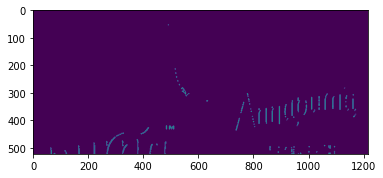

In [34]:
anna2_img = "/home/office5/ATE/Ketan_sir/testing_images/crop_block4/123[ 10 616].png"
anna2_img = cv2.imread(anna2_img,0)
thresh = cv2.threshold(anna2_img,10,245,cv2.THRESH_BINARY)[1]
edge = cv2.Canny(thresh, config['t_lower'], config['t_upper'], L2gradient = config['L2Gradient'])
plt.imshow(edge)
plt.show()

In [ ]:
# plt.imshow(defect_img)
# plt.show()

cv2.imwrite('1.png',original_img)
cv2.imwrite('2.png',defect_img)

True

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
image = "/home/office5/Image_Code/Ketan_sir/data/Anna2.bmp"
img = cv2.imread(image,0)
y, x = img.shape
n = 8
start_x = 2
start_y = 7
edge1 = img[start_y * y // n: (start_y + 1) * y // n, start_x * x // n:(start_x + 1) * x // n]
print(edge1.shape)
print(img.shape)
# show(edge1)

(392, 912)
(3136, 7296)


In [ ]:
height, width = img.shape
half_height,half_width = height//2, width//2
print(height,width)
print(half_height,half_width)

3136 7296
1568 3648


### Making four images from original images

In [ ]:
import cv2

In [ ]:
img = cv2.imread('/home/office5/Image_Code/Ketan_sir/data/Anna3.bmp')

In [ ]:
img.shape

(3136, 7296, 3)

In [ ]:
height , width,_ = img.shape
print(height,width)

3136 7296


In [ ]:
half_hei, half_wid = height // 2 , width //2
print(half_hei,half_wid)

1568 3648


In [ ]:
print("1st part of image ", " height ", 0       ,' - ',     half_hei,   ' width ',   0 ,' - ',  half_wid)
print("2nd part of image ", " height ", 0       ,' - ',     half_hei,   ' width ',  half_wid,   ' - ',width)
print("3rd part of image ", " height ", half_hei ,' - ',    height,     ' width ',   0 ,' - '   ,half_wid)
print("4th part of image ", " height ", 0       ,' - ',     half_hei,   ' width ',  half_wid,   ' - ',width)

1st part of image   height  0  -  1568  width  0  -  3648
2nd part of image   height  0  -  1568  width  3648  -  7296
3rd part of image   height  1568  -  3136  width  0  -  3648
4th part of image   height  0  -  1568  width  3648  -  7296


In [ ]:
print("Centre value of image of first part" ," height ", (0 + half_hei) // 2, " width ", (0 + half_wid) // 2)
print("Centre value of image of second part" ," height ", (0 + half_hei) // 2, " width ", (half_wid + width) // 2)
print("Centre value of image of third part" ," height ", (half_hei + height) // 2, " width ", (0 + half_wid) // 2)
print("Centre value of image of fourth part" ," height ", (half_hei + height) // 2, " width ", (half_wid + width) // 2)

Centre value of image of first part  height  784  width  1824
Centre value of image of second part  height  784  width  5472
Centre value of image of third part  height  2352  width  1824
Centre value of image of fourth part  height  2352  width  5472


In [ ]:
print(784 - 200, 784 + 200, 1824 -500, 1824 + 500)
print(784 - 200, 784 + 200, 5472 -500, 5472 + 500)
print(2352 - 200, 2352 + 200, 1824 -500, 1824 + 500)
print(2352 - 200, 2352 + 200, 5472 -500, 5472 + 500)

584 984 1324 2324
584 984 4972 5972
2152 2552 1324 2324
2152 2552 4972 5972


In [ ]:
first_img_crop = img[584:984,1324:2324]
second_img_crop = img[584:984,4972:5972]
third_img_crop = img[2152:2552,1324:2324]
fourth_img_crop = img[2152:2552,4972:5972]

In [ ]:
# plt.imshow(first_img_crop)
# plt.show()
# plt.imshow(second_img_crop)
# plt.show()
# plt.imshow(third_img_crop)
# plt.show()
# plt.imshow(fourth_img_crop)
# plt.show()

cv2.imwrite('first_img2_crop.png',first_img_crop)
cv2.imwrite('second_img2_crop.png',second_img_crop)
cv2.imwrite('third_img2_crop.png',third_img_crop)
cv2.imwrite('fourth_img2_crop.png',fourth_img_crop)

True